# Réseau de neurones

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
folder="C:\\Users\\quentin.mascart\\Documents\\Stage DAM\\CibNav\\"

In [4]:
Navire=pd.read_csv(folder+"Données\\Navire.csv")
Historique=pd.read_csv(folder+"Données\\Dataset_train.csv")
Base=pd.read_csv(folder+"Données\\Base.csv")

In [4]:
Navire=Navire[['ID Nav Flotteur', 'Annee Construction', 'Genre Navigation', 'Jauge Oslo', 'Longueur Hors Tout', 'Materiau Coque', 'Nombre Moteur', 'Num Version', 'Puissance Administrative', 'Situation Flotteur', 'Type Carburant', 'Type Moteur']]

In [5]:
Historique=Historique[['ID Nav Flotteur','Date Visite','Annee Visite','Sitrep History','Nombre Prescriptions','Nombre Prescriptions Majeurs']]

In [6]:
df=pd.merge(Historique,Navire,on='ID Nav Flotteur')

In [7]:
df['age']=df['Annee Visite']-df['Annee Construction']
del df['Annee Construction']

In [8]:
Data=df

In [9]:
Data['Tendance']=(df.groupby(['ID Nav Flotteur'])['Nombre Prescriptions'].shift(1)>df.groupby(['ID Nav Flotteur'])['Nombre Prescriptions'].shift(2))*1

In [10]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27803 entries, 0 to 27802
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID Nav Flotteur               27803 non-null  float64
 1   Date Visite                   27803 non-null  object 
 2   Annee Visite                  27803 non-null  int64  
 3   Sitrep History                27803 non-null  int64  
 4   Nombre Prescriptions          27803 non-null  float64
 5   Nombre Prescriptions Majeurs  27803 non-null  float64
 6   Genre Navigation              22510 non-null  object 
 7   Jauge Oslo                    25245 non-null  float64
 8   Longueur Hors Tout            27803 non-null  float64
 9   Materiau Coque                27803 non-null  object 
 10  Nombre Moteur                 27405 non-null  float64
 11  Num Version                   27803 non-null  float64
 12  Puissance Administrative      27287 non-null  float64
 13  S

In [11]:
Base['Tendance']=(df.groupby(['ID Nav Flotteur'])['Nombre Prescriptions'].shift(1)>df.groupby(['ID Nav Flotteur'])['Nombre Prescriptions'].shift(2))*1

# Apprentissage supervisé

### Chargement des packages + données

In [12]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer

In [13]:
#Création de la cible au moins une prescription majeure
Data['Cible'] = Data['Nombre Prescriptions Majeurs'].apply(lambda x: '1' if x > 0 else '0').astype(int)
#Création de la cible au moins une préscription majeure ou au moins 4 mineurs
Data['Cible_deux'] = Data['Cible'] + Data['Nombre Prescriptions'].apply(lambda x: '1' if x > 3 else '0').astype(int)
Data['Cible_deux'] = Data['Cible_deux'].apply(lambda x: '1' if x > 0 else '0').astype(int)

In [7]:
Base['Cible'].sum()/len(Base)

0.5428910549221307

### Création d'une classe pour intégrer les pondérations au gridsearch

Définitions des poids :

In [14]:
lag=max(Data['ID Nav Flotteur'].value_counts())
#Poid logarithmique
#On génère lag-points espacés logarithmiquement de 1 à 10
poids_log=list(np.logspace(0, 1, lag, endpoint=True))[::-1] #Pour décroissant
#Poids arithmétique
poids_arith=np.arange(lag)[::-1]
#Poids constant pour chaque visite
poids_const= list(np.ones(lag))[::-1]
#On ne prend en compte que la dernière visite
poids_prec= list(np.zeros(lag))[::-1]
poids_prec[0]=1.0

Définition de la fonction de pondération :
On applique un poids à chaque visite d'un bateau

In [15]:
def pondération(data,poids,variable,unite):
    """Cette fonction permet de selectionner un vecteur et de pondérer son historique en fonction
    de poids."""
    df= data.copy(deep=True)#On copie pour ne pas modifier directement notre Dataframe
    df["nom"]=0
    
    for i in range(0,len(poids)): #On boucle sur l'historique et on affecte un poids a chaque visite antérieure
        df["poids"]=poids[i]*df.groupby([unite])[variable].shift(i+1)
        df['nom'] = df.fillna(0)['nom'] + df.fillna(0)["poids"]
        
    del (df['poids'])
    df[variable]=df['nom']
    del (df['nom'])
    
    return(df)

In [16]:
Data=pondération(Data,poids_const,'Nombre Prescriptions Majeurs','ID Nav Flotteur')

In [17]:
Data=pondération(Data,poids_log,'Nombre Prescriptions','ID Nav Flotteur')

## Train/Test

##### Cible = au moins une prescription majeure ou au moins 4 Prescriptions mineures 

In [18]:
Base.columns

Index(['Age', 'Annee Construction', 'Annee Visite', 'Cible', 'Date Visite',
       'Delai Visites', 'Genre Navigation', 'ID Gin Visite', 'ID Nav Flotteur',
       'Jauge Oslo', 'Longueur Hors Tout', 'Materiau Coque', 'Nombre Moteur',
       'Nombre Prescriptions', 'Nombre Prescriptions Hist',
       'Nombre Prescriptions Majeurs', 'Nombre Prescriptions Majeurs Hist',
       'Num Version', 'Puissance Administrative', 'Sitrep History',
       'Situation Flotteur', 'Type Carburant', 'Type Moteur', 'Tendance'],
      dtype='object')

In [19]:
test_size=0.33
df=Base.copy()
df=df.sort_values(by='Date Visite')
del df["Date Visite"]
int(len(Data)*test_size)

#frac=1 : on shuffle les données.
X_train=df.head(int(len(Data)*(1-test_size))).sample(frac=1)
X_test=df.tail(int(len(Data)*(test_size))).sample(frac=1)

Y_train=X_train['Cible']
Y_test=X_test['Cible']

del X_train['Cible']
del X_test['Cible']
del X_train['Nombre Prescriptions']
del X_train['Nombre Prescriptions Majeurs']
del X_train['ID Gin Visite']
del X_train['Annee Construction']
del X_train['ID Nav Flotteur']
del X_test['Nombre Prescriptions']
del X_test['Nombre Prescriptions Majeurs']
del X_test['ID Gin Visite']
del X_test['Annee Construction']
del X_test['ID Nav Flotteur']

### Preprocessing

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [21]:
categories = ['Genre Navigation', 'Materiau Coque', 'Situation Flotteur', 'Type Carburant', 'Type Moteur']
numerique = ['Annee Visite', 'Jauge Oslo', 'Longueur Hors Tout', 'Num Version', 'Puissance Administrative','Nombre Prescriptions Hist','Nombre Prescriptions Majeurs Hist','Sitrep History','Age','Delai Visites','Tendance']
#Sans le nombre de moteur car traitement a part

In [22]:
categorical_preprocessing = Pipeline([('imputer_str', SimpleImputer(strategy="constant", fill_value='None')),
                                      ('ohe', OneHotEncoder(handle_unknown='ignore',sparse =False))]) 
#ATTENTION avec OneHotEncoder on ne gère pas les problèmes éventuels de multicolinéarité puisqu'on ne peut handle_unknown et drop:"first"

numeric_preprocessing = Pipeline(steps=[
    ("imputer_num", SimpleImputer(strategy="mean")), # La moyenne
    ("scaler", MaxAbsScaler())])

#Pour le nombre de moteur
numeric_preprocessing_moteur = Pipeline(steps=[
    ("imputer_num", SimpleImputer(strategy="most_frequent")), # Le plus fréquent
    ("scaler", MaxAbsScaler())])

preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, categories),
    ('numerical_preprocessing_mot', numeric_preprocessing_moteur, ['Nombre Moteur']),
    ('numerical_preprocessing', numeric_preprocessing, numerique)
    
])

### Classification

In [23]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([
    ('preprocess', preprocess),
    ('RF', RandomForestClassifier(n_estimators=200, max_depth=110, 
        min_samples_split=8, min_samples_leaf=3, max_features=3,bootstrap=True))
])

In [24]:
model=pipe.fit(X_train,Y_train)

In [25]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, model.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,2054,2248
vrai Pas de prescription majeure,1097,3775


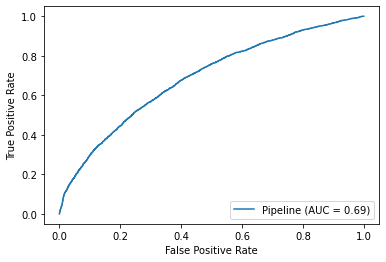

In [26]:
from sklearn.metrics import plot_roc_curve, recall_score, precision_score, roc_auc_score, make_scorer
svc_disp = plot_roc_curve(model, X_test, Y_test)
plt.show()

In [27]:
from sklearn.dummy import DummyClassifier

In [28]:
dummy = Pipeline([
    ('preprocess', preprocess),
    ('Dummy', DummyClassifier(strategy='stratified'))])
dummy.fit(X_train, Y_train.values.ravel())

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('imputer_str',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Genre Navigation',
                                                   'Materiau Coque',
                                                   'Situation Flotteur',
                                                   'Type Carburant',
                                           

In [29]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(Y_test, dummy.predict(X_test))
cf = pd.DataFrame(conf, columns=['prédit ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']])
cf.index = ['vrai ' + _ for _ in ['Prescription majeure', 'Pas de prescription majeure']]
cf

,prédit Prescription majeure,prédit Pas de prescription majeure
vrai Prescription majeure,1907,2395
vrai Pas de prescription majeure,2211,2661


In [30]:
RF_T=Y_test.array
RF_P=model.predict(X_test)
DUM_P=dummy.predict(X_test)

# Choix de nouveaux modèles

In [32]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm


In [33]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler,RobustScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [34]:
categories = ['Genre Navigation', 'Materiau Coque', 'Situation Flotteur', 'Type Carburant', 'Type Moteur']
numerique = ['Annee Visite', 'Jauge Oslo', 'Longueur Hors Tout', 'Num Version', 'Puissance Administrative','Nombre Prescriptions Hist','Nombre Prescriptions Majeurs Hist','Sitrep History','Age','Delai Visites','Tendance','Cible']
#Sans le nombre de moteur car traitement a part
categorical_preprocessing = Pipeline([('imputer_str', SimpleImputer(strategy="constant", fill_value='None')),
                                      ('ohe', OneHotEncoder(handle_unknown='ignore',sparse =False))]) 
#ATTENTION avec OneHotEncoder on ne gère pas les problèmes éventuels de multicolinéarité puisqu'on ne peut handle_unknown et drop:"first"

numeric_preprocessing = Pipeline(steps=[
    ("imputer_num", SimpleImputer(strategy="mean")), # La moyenne
    ("scaler", MaxAbsScaler())])

#Pour le nombre de moteur
numeric_preprocessing_moteur = Pipeline(steps=[
    ("imputer_num", SimpleImputer(strategy="most_frequent")), # Le plus fréquent
    ("scaler", MaxAbsScaler())])

preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, categories),
    ('numerical_preprocessing_mot', numeric_preprocessing_moteur, ['Nombre Moteur']),
    ('numerical_preprocessing', numeric_preprocessing, numerique)
    
])

In [35]:
test_size=0.33
df=Base.copy()
df=df.sort_values(by='Date Visite')

In [36]:
df=df[['Age',
 'Annee Visite',
 'Delai Visites',
 'Genre Navigation',
 'Jauge Oslo',
 'Longueur Hors Tout',
 'Materiau Coque',
 'Nombre Moteur',
 'Nombre Prescriptions Hist',
 'Nombre Prescriptions Majeurs Hist',
 'Num Version',
 'Puissance Administrative',
 'Sitrep History',
 'Situation Flotteur',
 'Type Carburant',
 'Type Moteur',
 'Tendance',
 'Cible']]

In [37]:
A=preprocess.fit_transform(df)

In [38]:
X_train=A[0:int(len(Base)*(1-test_size))]
X_test=A[int(len(Base)*(1-test_size)):len(Base)]

In [39]:
from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    
    def __init__(self, data):
        #Base
        file_out = data 
        x=data[1:18628,1:65]
        y=data[1:18628,65]
        
        #converting to torch tensors
        self.X_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.int64)
        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self,idx):
        return self.X_train[idx],self.y_train[idx]

In [40]:
all_train=FeatureDataset(X_train)
# We split the whole train set in two parts:
# the one that we actually use for training
# and the one that we use for validation
batch_size = 32  # size of the mini batch
num_train = int(0.8 * len(all_train))

trainset, valset = torch.utils.data.random_split(all_train, [num_train, len(all_train) - num_train])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

# Réseau de neurones

In [133]:
class SimpleFeedForward(nn.Module):
    def __init__(self, input_size=64, hidden_sizes=[128, 64, 32],
                 output_size=2,drop=0.5):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]), 
            nn.Dropout(drop),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], output_size)
        )

    def forward(self, x):
        x = x.reshape(-1, input_size)
        x = self.classifier(x)
        return x

# Evaluation

In [42]:
# Training consists of gradient steps over mini batch of data
def train(model, trainloader, loss, optimizer, epoch, num_epochs):
    # We enter train mode. This is useless for the linear model
    # but is important for layers such as dropout, batchnorm, ...
    model.train()
    
    loop = tqdm(trainloader)
    loop.set_description(f'Training Epoch [{epoch + 1}/{num_epochs}]')
    
    # We iterate over the mini batches of our data
    for inputs, targets in loop:
    
        # Erase any previously stored gradient
        optimizer.zero_grad()
        
        
        outputs = model(inputs) # Forwards stage (prediction with current weights)
        loss = criterion(outputs, targets) # loss evaluation
        
        loss.backward() # Back propagation (evaluate gradients) 
        
        
        # Making gradient step on the batch (this function takes care of the gradient step for us)
        optimizer.step()
        
def validation(model, valloader, loss):
    # Do not compute gradient, since we do not need it for validation step
    with torch.no_grad():
        # We enter evaluation mode.
        model.eval()
        
        total = 0 # keep track of currently used samples
        running_loss = 0.0 # accumulated loss without averagind
        accuracy = 0.0 # accumulated accuracy without averagind (number of correct predictions)
        
        loop = tqdm(valloader) # This is for the progress bar
        loop.set_description('Validation in progress')
        
        
        # We again iterate over the batches of validation data. batch_size does not play any role here
        for inputs, targets in loop:
            # Run samples through our net
            outputs = model(inputs)

            # Total number of used samples
            total += inputs.shape[0]

            # Multiply loss by the batch size to erase averagind on the batch
            running_loss += inputs.shape[0] * loss(outputs, targets).item()
            
            # how many correct predictions
            accuracy += (outputs.argmax(dim=1) == targets).sum().item()
            
            # set nice progress meassage
            loop.set_postfix(val_loss=(running_loss / total), val_acc=(accuracy / total))
        return running_loss / total, accuracy / total

In [142]:
# Net + training parameters

num_epochs = 10 # how many passes over the whole train data

input_size = 64 # flattened size of the image

hidden_sizes = [128, 64, 32] # sizes of hidden layers

output_size = 2 # how many labels we have

drop = 0

lr = 0.01 # learning rate

momentum = 0.7 # momentum

poids=torch.tensor([[1, 1]],dtype=torch.float32)#Poids

In [143]:
# initializing our model/loss/optimizer
net = SimpleFeedForward(input_size, hidden_sizes, output_size) # Our neural net
criterion = nn.CrossEntropyLoss(poids) # Loss function to be optimized
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum) # Optimization algorithm

In [144]:
# num_epochs indicates the number of passes over the data
for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)

In [147]:
testset = FeatureDataset(X_test)
loop = tqdm(testset) # This is for the progress bar
loop.set_description('Validation in progress')
L=[]
T=[]
P=[]

for inputs, targets in loop:
    # Run samples through our net
    outputs = net(inputs)
    L.append(outputs.argmax(dim=1))
    T.append(targets)
    P.append(outputs)

L = torch.stack(L)
P = torch.stack(P)
T = torch.stack(T)
P=P.detach().numpy()[:,0][:,0]
T=T.detach().numpy()
L=L.detach().numpy()

### Evaluation

In [87]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

# Dummy 

In [52]:
TP, FP, TN, FN = perf_measure(RF_T, RF_P)
print("Cible à 1")
print((TP+FP)/len(P))
print("part de cible à 1 correctement prédite")
print((TP)/(TP+FP))
print("part de cible à 0 correctement prédite")
print((TN)/(TN+FN))
print("Rappel")
print((TP)/(TP+FN))
print("F1")
print((TP)/(TP+(1/2)*(FP+FN)))

part de prescription majeure prédite
0.5494876825812077
part de prescription majeure correctement prédite
0.5288633207696886
part de prescription mineure correctement prédite
0.46624727800629084
Rappel
0.5472085385878489
F1
0.5378795521032987


# Random forest

In [53]:
TP, FP, TN, FN = perf_measure(RF_T, RF_P)
print("Cible à 1")
print((TP+FP)/len(P))
print("part de cible à 1 correctement prédite")
print((TP)/(TP+FP))
print("part de cible à 0 correctement prédite")
print((TN)/(TN+FN))
print("Rappel")
print((TP)/(TP+FN))
print("F1")
print((TP)/(TP+(1/2)*(FP+FN)))

part de prescription majeure prédite
0.6565293219969479
part de prescription majeure correctement prédite
0.6267640710609331
part de prescription mineure correctement prédite
0.6518565534750873
Rappel
0.7748357963875205
F1
0.6929784304726939


# NN

num_epochs = 10 # how many passes over the whole train data

input_size = 64 # flattened size of the image

hidden_sizes = [128,64] # sizes of hidden layers

output_size = 2 # how many labels we have

lr = 0.01 # learning rate

momentum = 0.9 # momentum

poids=torch.tensor([[1, 1]],dtype=torch.float32)#Poids

In [148]:
TP, FP, TN, FN = perf_measure(RF_T, RF_P)
print("Cible à 1")
print((TP+FP)/len(P))
print("part de cible à 1 correctement prédite")
print((TP)/(TP+FP))
print("part de cible à 0 correctement prédite")
print((TN)/(TN+FN))
print("Rappel")
print((TP)/(TP+FN))
print("F1")
print((TP)/(TP+(1/2)*(FP+FN)))

part de prescription majeure prédite
0.6477000218007413
part de prescription majeure correctement prédite
0.6127566475934029
part de prescription mineure correctement prédite
0.6191212871287128
Rappel
0.7473316912972086
F1
0.6733863510264472
